In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v1 adding last year data as input Z

by Louis Yang

Use Fibonacci series median instead of median. The Fib. median are now compute on both training and CV set separately.

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained CNN as prediction.

v0 Feed second input (median and stdev) to the neural network after the CNN part.

v0.3 Merge the original 0 and 1 groups and 4, 5 groups. Original 2,3 groups split into 2 based on stdev(> 1.7). Total number of groups is 6.

Test on stage 2 data.

Original model: 'model_10_Modified_CNN_0_median_stdev'

Ensemble: automatically evaluate the same model 4 times

In [2]:
model_name = 'model_10_Modified_CNN_1_Z'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_2.csv'

In [5]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file)
print('done!')

%%% Reading data train_2.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

In [183]:
input_df_temp = input_df[input_df_dates].astype('float32')

In [184]:
input_df_temp['Page'] = input_df['Page']

In [185]:
input_df = input_df_temp
del input_df_temp

In [186]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 794 entries, 2015-07-01 to Page
dtypes: float32(793), object(1)
memory usage: 439.9+ MB


In [187]:
input_df_dates = input_df.columns[:-1]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object', length=793)

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [188]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [189]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-04-29', '2016-06-30')

In [190]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [191]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [192]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-04-28', '2017-06-29')

In [193]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [194]:
weekday(X_input_first_day), weekday(X_output_first_day)

(4, 4)

Should be the same

#### Y

In [195]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [196]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-07-01', '2016-09-01')

In [197]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [198]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [199]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-06-30', '2017-08-31')

In [200]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [201]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(4, 4)

Should be the same

#### Z

In [202]:
Z_input_dates = input_df_dates[-test_length-364*2:y_length-test_length-364*2]; Z_input_dates

Index(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12',
       '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17',
       '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22',
       '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
       '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01',
       '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
       '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
       '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
       '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21',
       '2015-08-22', '2015-08-23', '2015-08-24', '2015-08-25', '2015-08-26',
       '2015-08-27', '2015-08-28', '2015-08-29', '2015-08-30', '2015-08-31',
       '2015-09-01', '2015-09-02', '2015-09-03'],
      dtype='object')

In [203]:
Z_input_first_day = Z_input_dates[0]
Z_input_final_day = Z_input_dates[-1]
Z_input_first_day, Z_input_final_day

('2015-07-03', '2015-09-03')

In [204]:
daydiff(Z_input_first_day, Z_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [205]:
# Z for output set
Z_output_dates = Y_input_dates
Z_output_dates

Index(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
       '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09', '2016-07-10',
       '2016-07-11', '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15',
       '2016-07-16', '2016-07-17', '2016-07-18', '2016-07-19', '2016-07-20',
       '2016-07-21', '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
       '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29', '2016-07-30',
       '2016-07-31', '2016-08-01', '2016-08-02', '2016-08-03', '2016-08-04',
       '2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
       '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
       '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19',
       '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-23', '2016-08-24',
       '2016-08-25', '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29',
       '2016-08-30', '2016-08-31', '2016-09-01'],
      dtype='object')

In [206]:
Z_output_first_day = Z_output_dates[0]
Z_output_final_day = Z_output_dates[-1]
Z_output_first_day, Z_output_final_day

('2016-07-01', '2016-09-01')

In [207]:
daydiff(Z_output_first_day, Z_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [208]:
weekday(Z_input_first_day), weekday(Z_output_first_day)

(4, 4)

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [209]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [210]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11',
        '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
        ...
        '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24', '2016-06-25',
        '2016-06-26', '2016-06-27', '2016-06-28', '2016-06-29', '2016-06-30'],
       dtype='object', length=329),
 Index(['2016-08-05', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
        '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
        ...
        '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
        '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29'],
       dtype='object', length=329))

In [211]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(4, 4)

In [212]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [213]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [214]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [215]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [216]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [217]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

We will use this as the center and part of the result

In [218]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

input_data contains X_input and Y_input array

In [219]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates, X_input_first_day, Y_input_final_day

(Index(['2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
        '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
        ...
        '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
        '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01'],
       dtype='object', length=126), '2016-04-29', '2016-09-01')

In [220]:
input_data = input_df[input_dates].values; #input_data  # input_data with nan

##### Convert nan to number 0.

In [221]:
input_data_num = np.nan_to_num(input_data); #input_data_num  # intput_data with nan -> 0.

input_data_num.shape

#### Z_input

In [222]:
Z_input_data_num = np.nan_to_num(input_df[Z_input_dates].values)

In [223]:
Z_input_data_num.shape

(145063, 63)

### Output Data

output_data for this self-testing script contains both X_output and Y_output

In [224]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates, X_output_first_day, X_output_final_day, Y_output_final_day

(Index(['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
        '2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07',
        ...
        '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
        '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
       dtype='object', length=126), '2017-04-28', '2017-06-29', '2017-08-31')

In [225]:
output_dates.shape

(126,)

In [226]:
output_data = input_df[output_dates].values; #output_data

##### Convert nan to number 0.

In [227]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[ 24.,  20.,  36., ...,  26.,  24.,  21.],
       [ 19.,  18.,  12., ...,  29.,  34.,  25.],
       [  2.,   0.,   3., ...,   8.,  12.,   9.],
       ..., 
       [ 27.,  84.,  14., ...,  21.,  11.,   9.],
       [  7.,  10.,  13., ...,   3.,   9.,   2.],
       [ 34.,  16.,  16., ...,   9.,   6.,   5.]], dtype=float32)

In [228]:
output_data_num.shape

(145063, 126)

### View

def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
        
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
    
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [229]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [230]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

In [231]:
Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [232]:
input_data_log.shape, input_data.shape, output_data_log.shape, output_data.shape

((145063, 126), (145063, 126), (145063, 126), (145063, 126))

In [233]:
Z_input_data_log.shape

(145063, 63)

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [234]:
#input_center = log(fib_input_median).reshape(-1,1)
output_center = log(fib_output_median).reshape(-1,1)
input_center = output_center  # using output_center instead

input_center, output_center

In [235]:
Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

In [236]:
Z_input_center.shape

(145063, 1)

#### Choice of default scale

In [237]:
input_raw_log = log(input_data)  # log of input_data with nan
output_raw_log = log(output_data)  # log of output_data with nan

np.median(np.nanstd(input_data_log[:,:x_length], axis=-1))

np.mean(np.nanstd(input_data_log[:,:x_length], axis=-1))

In [238]:
default_input_scale = np.nanmedian(np.nanstd(input_raw_log[:,:x_length], axis=-1))
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17974041

In [239]:
default_output_scale = np.nanmedian(np.nanstd(output_raw_log[:,:x_length], axis=-1))
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.16425449

#### Compute Median and Stdev

Here we are not using this median as center

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [240]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = default_input_scale  # Prevent divid by zero 
# non-zero value is choose based on the median of other page with non-zero stdev)
input_scale  # remember sample-wised scale

array([[ 0.22042467],
       [ 0.19443031],
       [ 0.23390391],
       ..., 
       [ 0.17974041],
       [ 0.17974041],
       [ 0.17974041]], dtype=float32)

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [241]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = default_output_scale  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.15715757],
       [ 0.23019141],
       [ 0.29932547],
       ..., 
       [ 0.30635026],
       [ 0.30876896],
       [ 0.41433722]], dtype=float32)

In [242]:
Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

array([[ 0.22026443],
       [ 0.34693086],
       [ 0.26398173],
       ..., 
       [ 0.17974041],
       [ 0.17974041],
       [ 0.17974041]], dtype=float32)

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [72]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [243]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

In [244]:
Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [78]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

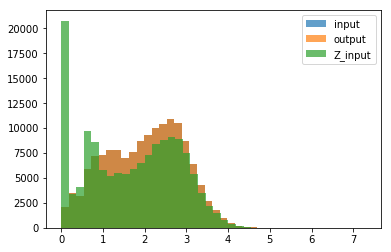

In [245]:
plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.hist(Z_input_center, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_center, bins=40, alpha=0.7, label='input')
plt.hist(output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

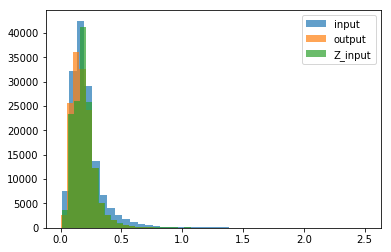

In [246]:
plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

def group_index(median, stdev):
    if median < 1.0: return 0
    elif median < 2.0: 
        if stdev < 1.7: return 1
        else: return 2
    elif median < 4.0: 
        if stdev < 1.7: return 3
        else: return 4
    else: return 5
#group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

In [82]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

input_gp = np.array([group_index(center, scale) for center, scale in zip(input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(output_center, output_scale)]).reshape(-1)

In [83]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)

In [84]:
input_gp, output_gp

(array([2, 2, 1, ..., 2, 1, 2]), array([2, 2, 1, ..., 2, 1, 2]))

In [87]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[1879, 23085, 43691, 75617, 740, 51]

In [88]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[1879, 23085, 43691, 75617, 740, 51]

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

## Make (X,Y) pairs data from data set

In [247]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [248]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


In [249]:
Z_output = Y_input

In [250]:
Z_input.shape, Z_output.shape

((145063, 63), (145063, 63))

#### Original data

In [251]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [252]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

X_input = X_input
Y_input = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

X_input_ori = X_input_ori
Y_input_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

In [94]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -104.945597725 182.183688699 0.0250217121081 3.34816141728
(145063, 63) -104.945597725 181.969627538 -0.0156385758122 3.42135990909
(145063, 63) -57.3465699314 8.00100800101 0.0 1.27077605981
(145063, 63) -1627.7382547 51.3918797946 -0.214767758227 6.0365527548
(145063, 63) 0.0 23209383.0 126.0 63765.8619057
(145063, 63) 0.0 67264258.0 128.0 155483.953622
(145063, 63) 0.0 24630674.0 123.0 65785.6552263
(145063, 63) 0.0 18670230.0 113.0 57469.0537846


In [97]:
arr_info((Z_input,))

shape, min, max, median, stdev
(145063, 63) -7.48869568243 8.00100800101 0.0 0.959453234932


#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, train_center, train_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [253]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

In [254]:
Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
input_center_list = [input_center[input_gp == gp] for gp in gp_list]
output_center_list = [output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [255]:
A_input = np.concatenate((input_center, input_scale), axis=1)
A_output = np.concatenate((output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [256]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [257]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [103]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [104]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [258]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [259]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(118.39848, 148.19037, 0.0)

In [260]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(60.41732, 58.828331)

In [261]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

50.9386 142.088


In [262]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

48.325
40.4041


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [110]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [116]:
n_ens = 5
ens_list = list(range(n_ens))

In [117]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_x = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        
        layer_z = Input(shape=(y_length,), name='z_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_z = Flatten()(layer_t)
                
        layer_t = concatenate([layer_cnn_x, layer_a, layer_cnn_z])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 1: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 2: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 3: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 
Run 4: Group-0 Group-1 Group-2 Group-3 Group-4 Group-5 


In [118]:
models_ens[0][1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_27 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
reshape_28 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_27 (Conv1D)               (None, 61, 120)       480         reshape_27[0][0]                 
___________________________________________________________________________________________

In [119]:
np.array(models_ens).shape

(5, 6)

In [120]:
len(gp_list)

6

In [122]:
epochs_list = [1,1,40,40,60,80]  # change to smaller epochs later (1,1,20,40,60,80)

In [123]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 1 / 5 ===
--- Group: 1 / 6 ---
Train on 1691 samples, validate on 188 samples
Epoch 1/1
3s - loss: 0.9578 - k_smape: 196.1645 - val_loss: 0.9723 - val_k_smape: 199.2199
--- Group: 2 / 6 ---
Train on 20776 samples, validate on 2309 samples
Epoch 1/1
4s - loss: 1.1274 - k_smape: 144.1884 - val_loss: 1.0329 - val_k_smape: 143.7398
--- Group: 3 / 6 ---
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
8s - loss: 1.3275 - k_smape: 127.2612 - val_loss: 1.0338 - val_k_smape: 121.6943
Epoch 2/40
8s - loss: 1.2581 - k_smape: 118.6847 - val_loss: 1.0493 - val_k_smape: 121.4051
Epoch 3/40
8s - loss: 1.2322 - k_smape: 116.8031 - val_loss: 1.0100 - val_k_smape: 113.9724
Epoch 4/40
8s - loss: 1.2245 - k_smape: 115.5416 - val_loss: 1.0062 - val_k_smape: 116.7781
Epoch 5/40
8s - loss: 1.2089 - k_smape: 114.6865 - val_loss: 1.0260 - val_k_smape: 120.2211
Epoch 6/40
8s - loss: 1.2120 - k_smape: 114.8843 - val_loss: 1.0598 - val_k_smape: 121.2738
Epoch 7/40
8s - loss: 1.2010 - k_smape:

0s - loss: 2.1023 - k_smape: 117.1953 - val_loss: 2.1068 - val_k_smape: 117.8313
Epoch 6/60
0s - loss: 1.9969 - k_smape: 116.6763 - val_loss: 1.8895 - val_k_smape: 113.5039
Epoch 7/60
0s - loss: 1.9405 - k_smape: 110.4284 - val_loss: 2.0685 - val_k_smape: 114.7142
Epoch 8/60
0s - loss: 1.9031 - k_smape: 109.3329 - val_loss: 1.5724 - val_k_smape: 106.7071
Epoch 9/60
0s - loss: 1.8490 - k_smape: 106.6132 - val_loss: 2.1030 - val_k_smape: 114.0186
Epoch 10/60
0s - loss: 1.8370 - k_smape: 104.6489 - val_loss: 1.7479 - val_k_smape: 108.1054
Epoch 11/60
0s - loss: 1.7852 - k_smape: 104.1328 - val_loss: 1.5224 - val_k_smape: 103.0262
Epoch 12/60
0s - loss: 1.7844 - k_smape: 99.9104 - val_loss: 2.0577 - val_k_smape: 108.8644
Epoch 13/60
0s - loss: 1.7141 - k_smape: 98.7112 - val_loss: 1.7571 - val_k_smape: 105.0888
Epoch 14/60
0s - loss: 1.7530 - k_smape: 99.4375 - val_loss: 1.5425 - val_k_smape: 97.8570
Epoch 15/60
0s - loss: 1.7185 - k_smape: 95.8031 - val_loss: 1.7710 - val_k_smape: 106.225

0s - loss: 3.7064 - k_smape: 97.2917 - val_loss: 1.5475 - val_k_smape: 96.7272
Epoch 41/80
0s - loss: 3.9199 - k_smape: 98.8274 - val_loss: 1.2624 - val_k_smape: 94.0117
Epoch 42/80
0s - loss: 3.4977 - k_smape: 92.2413 - val_loss: 1.1562 - val_k_smape: 91.7495
Epoch 43/80
0s - loss: 3.5059 - k_smape: 90.6434 - val_loss: 1.1583 - val_k_smape: 91.2349
Epoch 44/80
0s - loss: 3.6267 - k_smape: 90.3254 - val_loss: 1.1484 - val_k_smape: 90.5248
Epoch 45/80
0s - loss: 3.3747 - k_smape: 88.0931 - val_loss: 1.1679 - val_k_smape: 90.2617
Epoch 46/80
0s - loss: 3.4381 - k_smape: 91.8919 - val_loss: 1.2794 - val_k_smape: 90.7149
Epoch 47/80
0s - loss: 3.3060 - k_smape: 88.2306 - val_loss: 1.4849 - val_k_smape: 92.1617
Epoch 48/80
0s - loss: 3.1057 - k_smape: 83.0068 - val_loss: 1.7471 - val_k_smape: 93.3479
Epoch 49/80
0s - loss: 3.4556 - k_smape: 90.5222 - val_loss: 1.9036 - val_k_smape: 94.6899
Epoch 50/80
0s - loss: 3.2350 - k_smape: 86.3507 - val_loss: 1.9527 - val_k_smape: 94.9262
Epoch 51/80

13s - loss: 1.2213 - k_smape: 99.0113 - val_loss: 1.1264 - val_k_smape: 107.9774
Epoch 5/40
13s - loss: 1.2117 - k_smape: 98.2478 - val_loss: 1.1077 - val_k_smape: 105.8868
Epoch 6/40
13s - loss: 1.2072 - k_smape: 98.0358 - val_loss: 1.0976 - val_k_smape: 105.8859
Epoch 7/40
13s - loss: 1.2017 - k_smape: 97.6307 - val_loss: 1.1063 - val_k_smape: 106.7933
Epoch 8/40
13s - loss: 1.2017 - k_smape: 97.6953 - val_loss: 1.1073 - val_k_smape: 106.4793
Epoch 9/40
13s - loss: 1.1950 - k_smape: 97.3692 - val_loss: 1.1175 - val_k_smape: 106.0875
Epoch 10/40
13s - loss: 1.1944 - k_smape: 97.1439 - val_loss: 1.1339 - val_k_smape: 106.1000
Epoch 11/40
13s - loss: 1.1906 - k_smape: 96.9366 - val_loss: 1.0876 - val_k_smape: 106.4309
Epoch 12/40
13s - loss: 1.1828 - k_smape: 96.8457 - val_loss: 1.1106 - val_k_smape: 105.4103
Epoch 13/40
13s - loss: 1.1847 - k_smape: 96.7981 - val_loss: 1.1040 - val_k_smape: 105.7889
Epoch 14/40
13s - loss: 1.1790 - k_smape: 96.6834 - val_loss: 1.1060 - val_k_smape: 107

0s - loss: 1.3344 - k_smape: 80.1366 - val_loss: 1.3175 - val_k_smape: 86.9021
Epoch 54/60
0s - loss: 1.3363 - k_smape: 81.4938 - val_loss: 1.3153 - val_k_smape: 89.0968
Epoch 55/60
0s - loss: 1.3226 - k_smape: 80.0037 - val_loss: 1.4323 - val_k_smape: 86.8260
Epoch 56/60
0s - loss: 1.3516 - k_smape: 79.7467 - val_loss: 1.2858 - val_k_smape: 85.5466
Epoch 57/60
0s - loss: 1.3289 - k_smape: 79.5355 - val_loss: 1.3698 - val_k_smape: 86.6362
Epoch 58/60
0s - loss: 1.3312 - k_smape: 81.7727 - val_loss: 1.4602 - val_k_smape: 85.8790
Epoch 59/60
0s - loss: 1.2807 - k_smape: 78.0599 - val_loss: 1.3074 - val_k_smape: 84.1425
Epoch 60/60
0s - loss: 1.3648 - k_smape: 78.7337 - val_loss: 1.5310 - val_k_smape: 88.3375
--- Group: 6 / 6 ---
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8483 - k_smape: 174.5125 - val_loss: 4.5073 - val_k_smape: 159.5136
Epoch 2/80
0s - loss: 6.5571 - k_smape: 166.2604 - val_loss: 4.1333 - val_k_smape: 146.2815
Epoch 3/80
0s - loss: 6.2588 - k_sma

0s - loss: 0.9398 - k_smape: 198.8452 - val_loss: 0.9776 - val_k_smape: 199.8660
--- Group: 2 / 6 ---
Train on 20776 samples, validate on 2309 samples
Epoch 1/1
4s - loss: 1.1388 - k_smape: 144.6643 - val_loss: 0.9887 - val_k_smape: 136.5552
--- Group: 3 / 6 ---
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
8s - loss: 1.3320 - k_smape: 127.8701 - val_loss: 1.0307 - val_k_smape: 120.6925
Epoch 2/40
8s - loss: 1.2521 - k_smape: 118.4075 - val_loss: 1.0356 - val_k_smape: 118.4286
Epoch 3/40
8s - loss: 1.2262 - k_smape: 116.1856 - val_loss: 1.0854 - val_k_smape: 124.6069
Epoch 4/40
8s - loss: 1.2146 - k_smape: 115.5974 - val_loss: 1.0823 - val_k_smape: 128.9570
Epoch 5/40
8s - loss: 1.2136 - k_smape: 115.1935 - val_loss: 1.0617 - val_k_smape: 119.5110
Epoch 6/40
8s - loss: 1.2061 - k_smape: 114.7604 - val_loss: 1.0780 - val_k_smape: 122.6916
Epoch 7/40
8s - loss: 1.2009 - k_smape: 114.3114 - val_loss: 1.0583 - val_k_smape: 117.9681
Epoch 8/40
8s - loss: 1.2024 - k_smape: 114.

0s - loss: 2.1129 - k_smape: 120.1858 - val_loss: 2.4571 - val_k_smape: 125.2122
Epoch 6/60
0s - loss: 2.0492 - k_smape: 119.7222 - val_loss: 1.8662 - val_k_smape: 111.6850
Epoch 7/60
0s - loss: 1.9727 - k_smape: 112.5230 - val_loss: 2.2662 - val_k_smape: 119.4872
Epoch 8/60
0s - loss: 1.9040 - k_smape: 113.3267 - val_loss: 1.6389 - val_k_smape: 108.5894
Epoch 9/60
0s - loss: 1.8875 - k_smape: 108.1995 - val_loss: 2.0498 - val_k_smape: 112.8533
Epoch 10/60
0s - loss: 1.8582 - k_smape: 105.2916 - val_loss: 1.5256 - val_k_smape: 103.7220
Epoch 11/60
0s - loss: 1.8113 - k_smape: 106.0931 - val_loss: 1.9279 - val_k_smape: 112.6330
Epoch 12/60
0s - loss: 1.7148 - k_smape: 102.6657 - val_loss: 1.5278 - val_k_smape: 105.3501
Epoch 13/60
0s - loss: 1.7152 - k_smape: 102.6915 - val_loss: 1.7945 - val_k_smape: 108.8728
Epoch 14/60
0s - loss: 1.6416 - k_smape: 98.6665 - val_loss: 1.6368 - val_k_smape: 104.1637
Epoch 15/60
0s - loss: 1.6397 - k_smape: 99.0758 - val_loss: 1.8283 - val_k_smape: 104.

0s - loss: 3.7962 - k_smape: 99.0894 - val_loss: 1.4225 - val_k_smape: 94.7950
Epoch 39/80
0s - loss: 3.6975 - k_smape: 94.8934 - val_loss: 1.5724 - val_k_smape: 95.2628
Epoch 40/80
0s - loss: 3.7814 - k_smape: 97.3421 - val_loss: 1.7565 - val_k_smape: 96.4190
Epoch 41/80
0s - loss: 3.7188 - k_smape: 98.0080 - val_loss: 1.8227 - val_k_smape: 96.8038
Epoch 42/80
0s - loss: 3.5717 - k_smape: 97.0618 - val_loss: 1.7536 - val_k_smape: 95.8698
Epoch 43/80
0s - loss: 3.6146 - k_smape: 93.7246 - val_loss: 1.5748 - val_k_smape: 94.2278
Epoch 44/80
0s - loss: 3.6410 - k_smape: 93.4856 - val_loss: 1.3400 - val_k_smape: 92.0704
Epoch 45/80
0s - loss: 3.3198 - k_smape: 89.1163 - val_loss: 1.1798 - val_k_smape: 90.8640
Epoch 46/80
0s - loss: 3.3571 - k_smape: 90.8992 - val_loss: 1.1360 - val_k_smape: 90.4530
Epoch 47/80
0s - loss: 3.4682 - k_smape: 89.0622 - val_loss: 1.1154 - val_k_smape: 89.5961
Epoch 48/80
0s - loss: 3.5442 - k_smape: 84.5872 - val_loss: 1.0916 - val_k_smape: 88.7759
Epoch 49/80

14s - loss: 1.2446 - k_smape: 100.5670 - val_loss: 1.1365 - val_k_smape: 108.9454
Epoch 3/40
14s - loss: 1.2223 - k_smape: 99.3939 - val_loss: 1.1530 - val_k_smape: 107.9033
Epoch 4/40
14s - loss: 1.2120 - k_smape: 98.6608 - val_loss: 1.0974 - val_k_smape: 106.7930
Epoch 5/40
14s - loss: 1.2042 - k_smape: 98.0074 - val_loss: 1.0914 - val_k_smape: 105.4045
Epoch 6/40
14s - loss: 1.1993 - k_smape: 97.6643 - val_loss: 1.1150 - val_k_smape: 105.7800
Epoch 7/40
14s - loss: 1.1924 - k_smape: 97.3012 - val_loss: 1.1021 - val_k_smape: 104.4741
Epoch 8/40
14s - loss: 1.1928 - k_smape: 97.1282 - val_loss: 1.1314 - val_k_smape: 105.7247
Epoch 9/40
14s - loss: 1.1891 - k_smape: 96.8745 - val_loss: 1.1510 - val_k_smape: 106.8345
Epoch 10/40
14s - loss: 1.1851 - k_smape: 96.8503 - val_loss: 1.1119 - val_k_smape: 105.1308
Epoch 11/40
14s - loss: 1.1834 - k_smape: 96.4830 - val_loss: 1.1254 - val_k_smape: 106.0131
Epoch 12/40
14s - loss: 1.1783 - k_smape: 96.5197 - val_loss: 1.0997 - val_k_smape: 104.

0s - loss: 1.3621 - k_smape: 82.2014 - val_loss: 1.4361 - val_k_smape: 87.0871
Epoch 52/60
0s - loss: 1.3731 - k_smape: 80.0814 - val_loss: 1.5149 - val_k_smape: 86.7170
Epoch 53/60
0s - loss: 1.3633 - k_smape: 79.5728 - val_loss: 1.3019 - val_k_smape: 85.9911
Epoch 54/60
0s - loss: 1.3185 - k_smape: 80.5404 - val_loss: 1.2621 - val_k_smape: 85.5429
Epoch 55/60
0s - loss: 1.4011 - k_smape: 78.5828 - val_loss: 1.6976 - val_k_smape: 90.4386
Epoch 56/60
0s - loss: 1.3872 - k_smape: 80.3661 - val_loss: 1.3238 - val_k_smape: 85.3082
Epoch 57/60
0s - loss: 1.4163 - k_smape: 79.7904 - val_loss: 1.5760 - val_k_smape: 88.3009
Epoch 58/60
0s - loss: 1.3410 - k_smape: 81.0630 - val_loss: 1.2749 - val_k_smape: 83.2103
Epoch 59/60
0s - loss: 1.3723 - k_smape: 78.6044 - val_loss: 1.4402 - val_k_smape: 85.9432
Epoch 60/60
0s - loss: 1.3536 - k_smape: 81.5165 - val_loss: 1.3426 - val_k_smape: 84.3408
--- Group: 6 / 6 ---
Train on 45 samples, validate on 6 samples
Epoch 1/80
0s - loss: 6.8604 - k_smape

Train on 1691 samples, validate on 188 samples
Epoch 1/1
1s - loss: 0.9414 - k_smape: 198.6142 - val_loss: 0.9781 - val_k_smape: 199.9685
--- Group: 2 / 6 ---
Train on 20776 samples, validate on 2309 samples
Epoch 1/1
5s - loss: 1.1314 - k_smape: 144.6689 - val_loss: 0.9903 - val_k_smape: 126.0418
--- Group: 3 / 6 ---
Train on 39321 samples, validate on 4370 samples
Epoch 1/40
8s - loss: 1.3289 - k_smape: 127.5388 - val_loss: 1.0255 - val_k_smape: 115.0330
Epoch 2/40
8s - loss: 1.2472 - k_smape: 118.3829 - val_loss: 1.0489 - val_k_smape: 119.1206
Epoch 3/40
8s - loss: 1.2291 - k_smape: 116.7395 - val_loss: 1.0491 - val_k_smape: 120.1677
Epoch 4/40
8s - loss: 1.2189 - k_smape: 115.6747 - val_loss: 1.0287 - val_k_smape: 117.4598
Epoch 5/40
8s - loss: 1.2136 - k_smape: 115.0858 - val_loss: 1.0480 - val_k_smape: 122.0588
Epoch 6/40
8s - loss: 1.2128 - k_smape: 114.5335 - val_loss: 1.0360 - val_k_smape: 117.0994
Epoch 7/40
8s - loss: 1.2046 - k_smape: 114.2496 - val_loss: 1.0694 - val_k_sma

0s - loss: 2.0772 - k_smape: 121.1089 - val_loss: 1.9857 - val_k_smape: 117.5322
Epoch 6/60
0s - loss: 1.9647 - k_smape: 116.5988 - val_loss: 1.7925 - val_k_smape: 110.7908
Epoch 7/60
0s - loss: 1.9327 - k_smape: 111.6191 - val_loss: 2.3092 - val_k_smape: 118.2929
Epoch 8/60
0s - loss: 1.9897 - k_smape: 111.4983 - val_loss: 1.8806 - val_k_smape: 113.5096
Epoch 9/60
0s - loss: 1.9503 - k_smape: 113.5454 - val_loss: 1.6488 - val_k_smape: 108.6847
Epoch 10/60
0s - loss: 1.8473 - k_smape: 106.1982 - val_loss: 1.8654 - val_k_smape: 111.9852
Epoch 11/60
0s - loss: 1.7349 - k_smape: 107.7355 - val_loss: 1.5595 - val_k_smape: 107.4351
Epoch 12/60
0s - loss: 1.8252 - k_smape: 103.4583 - val_loss: 2.0407 - val_k_smape: 113.3209
Epoch 13/60
0s - loss: 1.7404 - k_smape: 103.9517 - val_loss: 1.5570 - val_k_smape: 102.6783
Epoch 14/60
0s - loss: 1.6999 - k_smape: 99.1785 - val_loss: 1.7122 - val_k_smape: 106.8955
Epoch 15/60
0s - loss: 1.7395 - k_smape: 98.3813 - val_loss: 1.6872 - val_k_smape: 106.

0s - loss: 3.6363 - k_smape: 99.7109 - val_loss: 1.7295 - val_k_smape: 99.4549
Epoch 38/80
0s - loss: 3.6375 - k_smape: 96.7170 - val_loss: 1.8220 - val_k_smape: 99.1462
Epoch 39/80
0s - loss: 3.6220 - k_smape: 97.3849 - val_loss: 1.8145 - val_k_smape: 97.9092
Epoch 40/80
0s - loss: 3.5066 - k_smape: 95.6497 - val_loss: 1.7486 - val_k_smape: 96.8711
Epoch 41/80
0s - loss: 3.3881 - k_smape: 92.9331 - val_loss: 1.6863 - val_k_smape: 95.5968
Epoch 42/80
0s - loss: 3.6548 - k_smape: 93.5501 - val_loss: 1.7050 - val_k_smape: 95.4361
Epoch 43/80
0s - loss: 3.5598 - k_smape: 90.7021 - val_loss: 1.7198 - val_k_smape: 95.8851
Epoch 44/80
0s - loss: 3.5144 - k_smape: 90.9795 - val_loss: 1.7215 - val_k_smape: 97.8077
Epoch 45/80
0s - loss: 3.6424 - k_smape: 92.0827 - val_loss: 1.6895 - val_k_smape: 98.8248
Epoch 46/80
0s - loss: 3.4749 - k_smape: 94.7801 - val_loss: 1.5892 - val_k_smape: 98.7160
Epoch 47/80
0s - loss: 3.4650 - k_smape: 95.3623 - val_loss: 1.4643 - val_k_smape: 96.5653
Epoch 48/80

### Training History

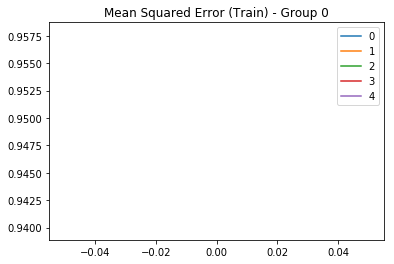

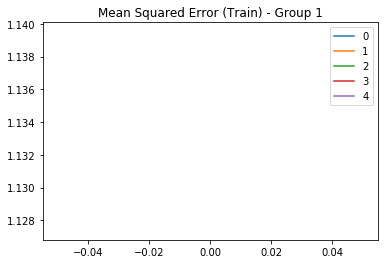

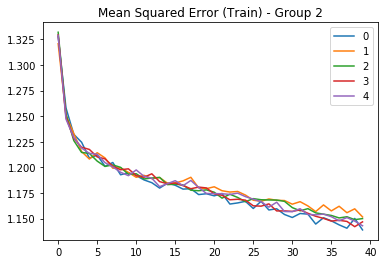

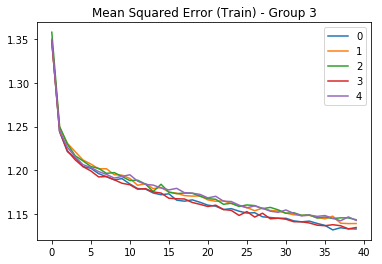

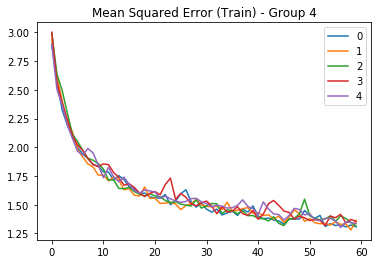

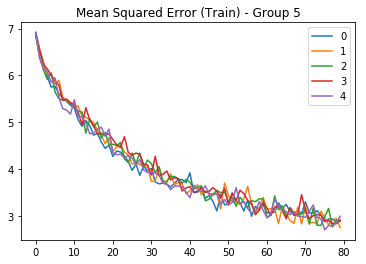

In [124]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

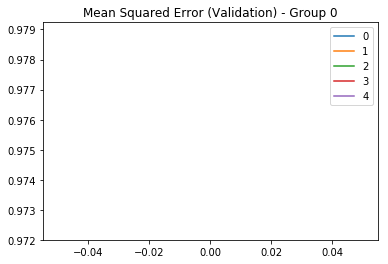

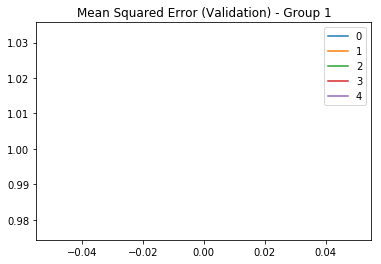

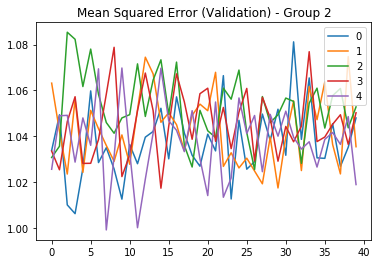

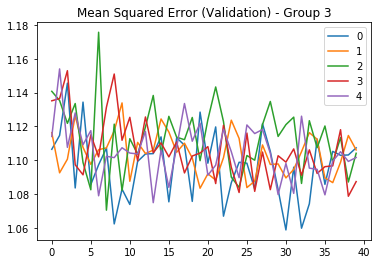

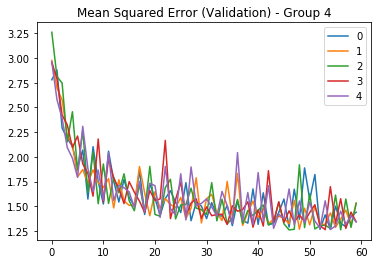

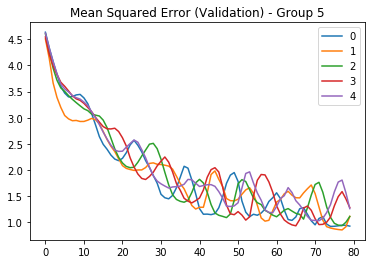

In [125]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

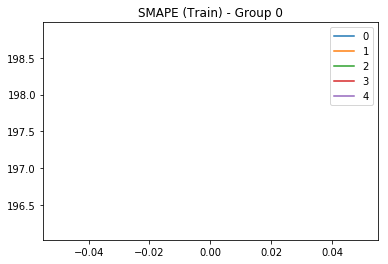

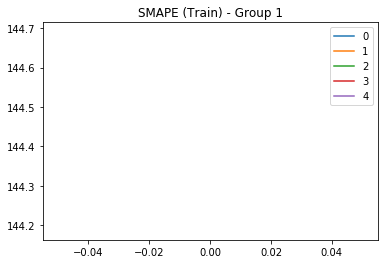

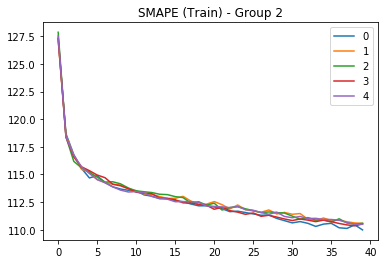

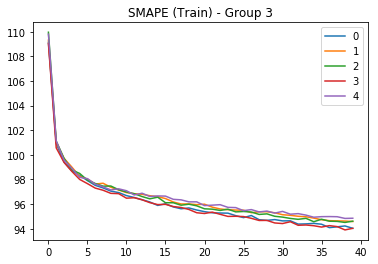

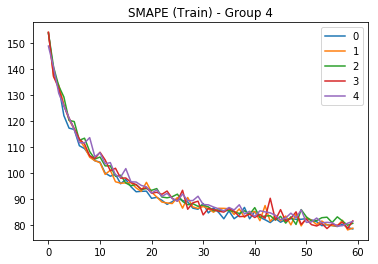

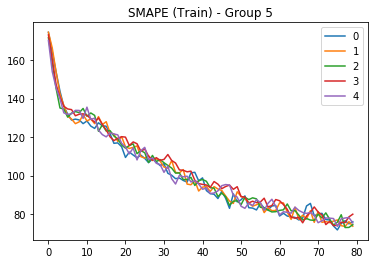

In [126]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

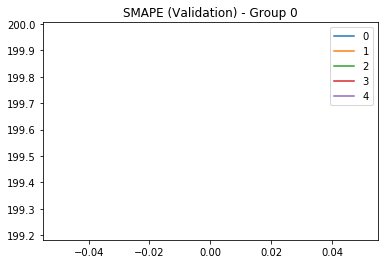

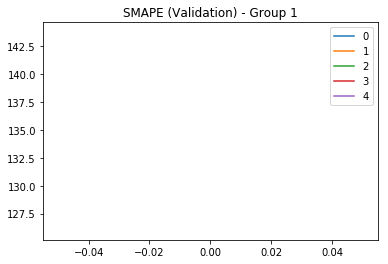

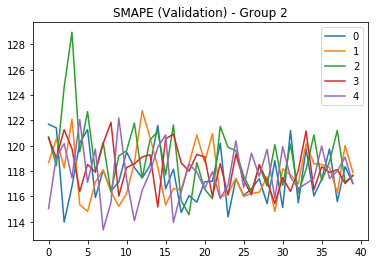

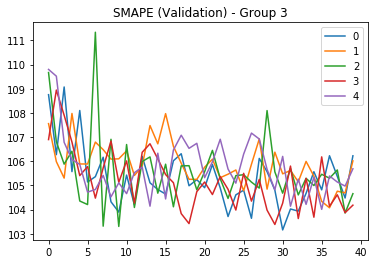

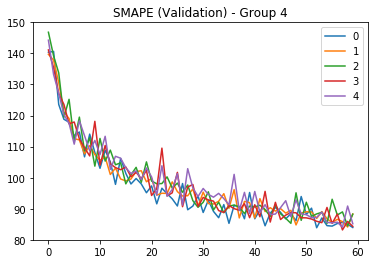

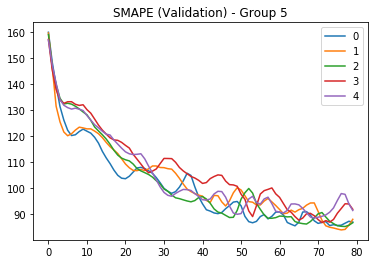

In [127]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

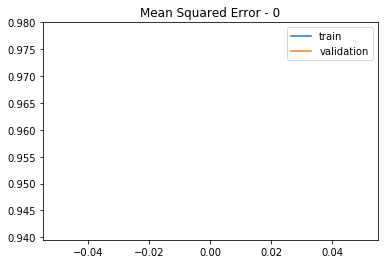

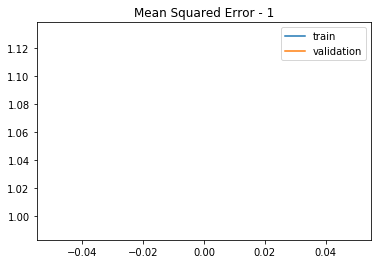

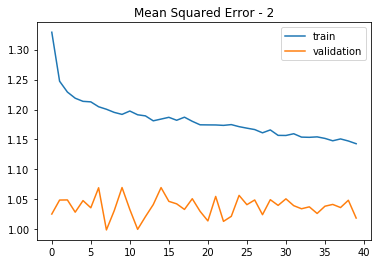

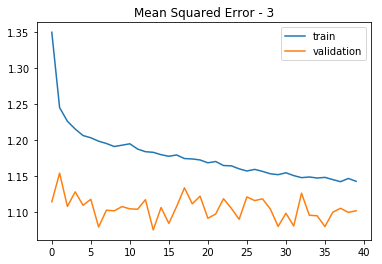

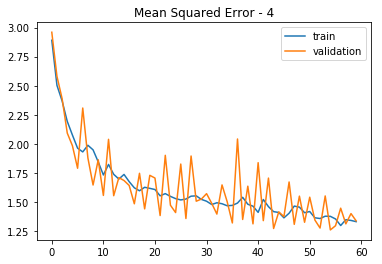

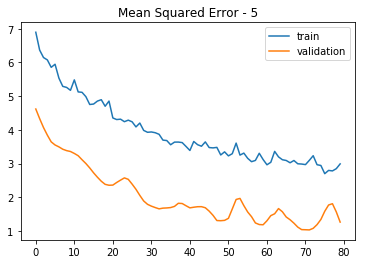

In [128]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

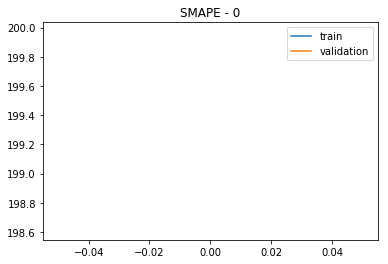

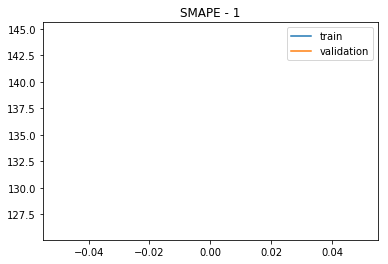

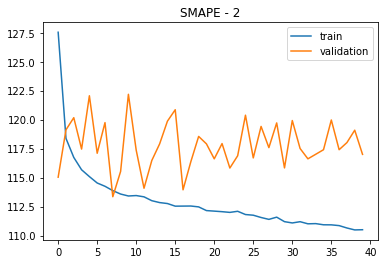

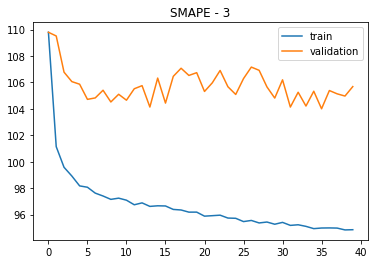

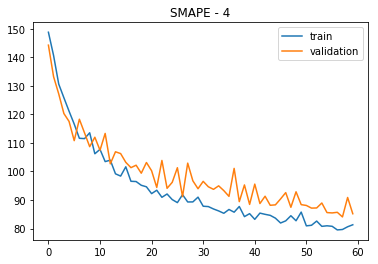

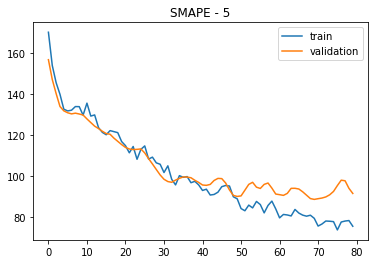

In [129]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

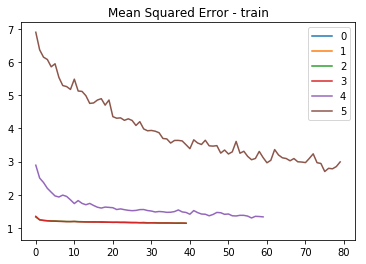

In [130]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

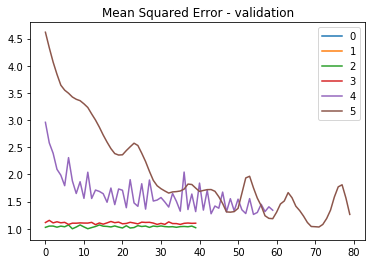

In [131]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

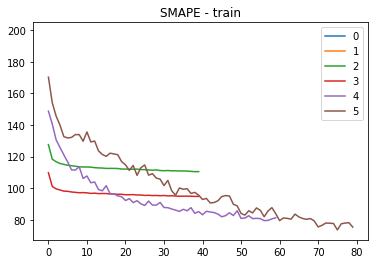

In [132]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

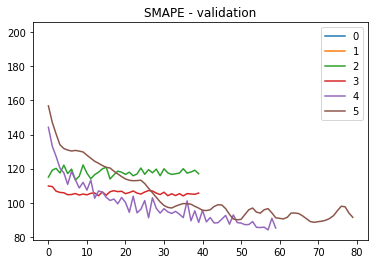

In [133]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Output Set

In [134]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 4 5 
Run 1: 0 1 2 3 4 5 
Run 2: 0 1 2 3 4 5 
Run 3: 0 1 2 3 4 5 
Run 4: 0 1 2 3 4 5 
Wall time: 1min 23s


Find the original index

In [135]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [136]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [137]:
for o in output_index_list:
    print(o.shape, end=' ')

(1879,) (23085,) (43691,) (75617,) (740,) (51,) 

In [138]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [139]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [140]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          output_center, output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [141]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        print(model_smape, model_smape_0)
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    print('-----------')
    print(model_smape_ens_mean, model_smape_0_ens_mean)

38.881236409 42.6998502081
38.8691032863 42.6711720679
38.8966598238 42.6042643154
39.1219018519 42.8753396806
38.9143396474 41.6899961751
-----------
38.9366482037 42.5081244894


In [142]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

40.4041165988


### Group Scores

In [143]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [144]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [145]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [146]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [147]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [148]:
# Group scores for the model
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    #gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
    #              in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [149]:
gp_smape_mean = np.mean(gp_smape_ens, axis=0); gp_smape_mean

array([ 158.87629838,   64.05722994,   40.02532147,   29.75491563,
         33.98336122,   17.25923362])

In [150]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [151]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |

#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|  Total |  40.404 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Page Scores

In [152]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [153]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

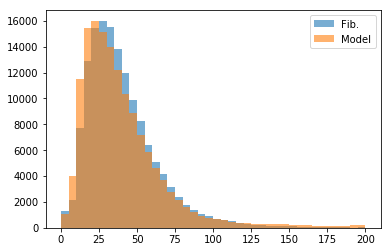

In [155]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [156]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [157]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

#### Plots

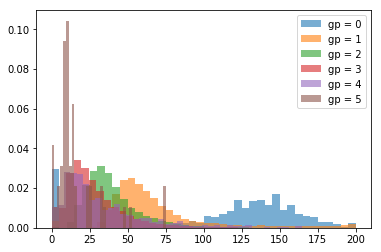

In [158]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

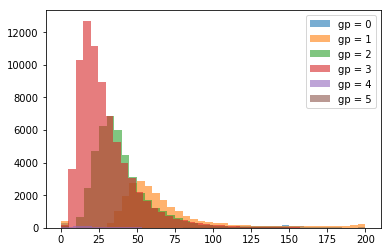

In [159]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

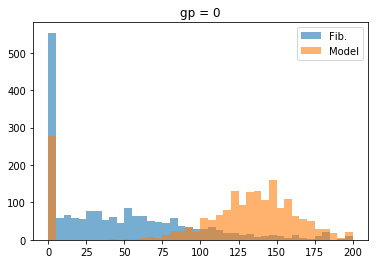

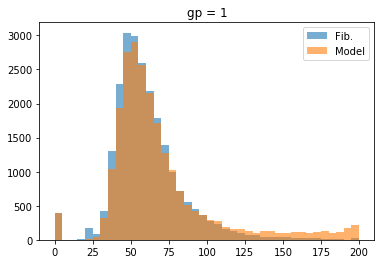

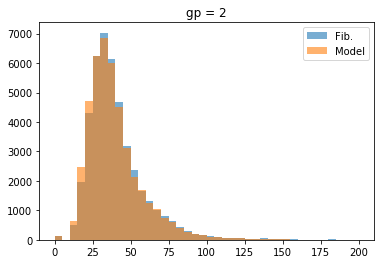

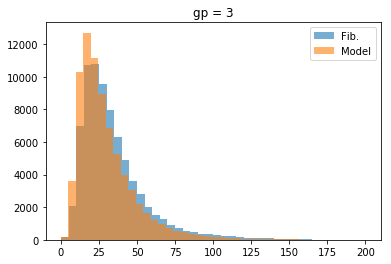

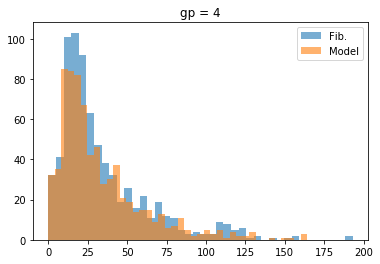

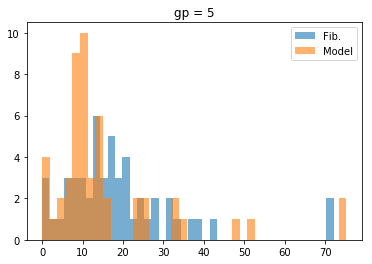

In [160]:
if test_length:
    for gp in gp_list:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
        plt.title('gp = '+str(gp)); plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [161]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [162]:
# Select group 0 from Fib.
#fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [163]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [164]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [165]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

37.824 (38.881) - model_10_Modified_CNN_1_Z 0
37.757 (38.869) - model_10_Modified_CNN_1_Z 1
37.818 (38.897) - model_10_Modified_CNN_1_Z 2
37.897 (39.122) - model_10_Modified_CNN_1_Z 3
37.734 (38.914) - model_10_Modified_CNN_1_Z 4
37.806 (38.937) - model_10_Modified_CNN_1_Z Average


## Ensemble Learning

### Ensemble Median

In [166]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [167]:
ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); ens_med_smape

38.749152986302413

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

#Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

Y_output_pred_ori_ens_med

In [168]:
#Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med  # Our final output
#Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
#Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

## All Model Scores

In [169]:
if test_length:  # Ensemble learning model score
    #f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    #f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    #f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [182]:
if test_length: # The_score with (without) combining Fibonacci median model
    #print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    #print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    #print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

37.473 (38.749) - model_10_Modified_CNN_1_Z ori_ensemble_median
37.806 (38.937) - model_10_Modified_CNN_1_Z Average
37.824 (38.881) - model_10_Modified_CNN_1_Z 0
37.757 (38.869) - model_10_Modified_CNN_1_Z 1
37.818 (38.897) - model_10_Modified_CNN_1_Z 2
37.897 (39.122) - model_10_Modified_CNN_1_Z 3
37.734 (38.914) - model_10_Modified_CNN_1_Z 4


37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

#### Combined Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [171]:
# ensemble result Y_output in each group
#Y_output_pred_ori_ens_mean_list = [Y_output_pred_ori_ens_mean[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_mean_ori_list = [Y_output_pred_ens_mean_ori[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_med_ori_list = [Y_output_pred_ens_med_ori[output_gp == gp] for gp in gp_list]

In [172]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    #gp_omean_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_mean_list)]
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]
    #gp_meano_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_mean_ori_list)]


In [173]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        #print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        #print(' %7.3f ' % gp_meano_smape[gp], end='|')
        #print(' %7.3f ' % gp_medo_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_1_Z
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 182.401 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  63.892 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  39.629 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.361 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.720 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.093 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|Over All|  40.404 |  37.473 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |

#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## More Explore

### Group Models in other Groups

In [175]:
%%time
smape_gpm_gp_ens = []
for run in ens_list:
    print('Run', run)
    models = models_ens[run]
    Y_output_all_ori_list = unlog(np.array([untransform(model.predict([X_output, A_output, Z_output]), 
                                                        output_center, output_scale) 
                                            for model in models]))
    # row: model of the group; column: group of Y
    smape_gpm_gp = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                    for Y_p in Y_output_all_ori_list]
    smape_gpm_gp_ens.append(smape_gpm_gp)

Run 0
Run 1
Run 2
Run 3
Run 4
Wall time: 7min 7s


In [176]:
smape_gpm_gp_ens = np.array(smape_gpm_gp_ens)

In [177]:
smape_gpm_gp_mean = np.mean(smape_gpm_gp_ens, axis=0)

In [178]:
print('Ensemble avg  ', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print(' group', j, end='|')
print('')
print('--------------', end='|')
for j in range(len(smape_gpm_gp_mean[0])): print('--------', end='|')
print('')
for i in range(len(smape_gpm_gp_mean)):
    print('group model', i, end=' |')
    for j in range(len(smape_gpm_gp_mean[0])):
        print(' %6.2f ' % smape_gpm_gp_mean[i][j], end='|')
    print('')

Ensemble avg  | group 0| group 1| group 2| group 3| group 4| group 5|
--------------|--------|--------|--------|--------|--------|--------|
group model 0 | 158.88 |  61.37 |  40.62 |  34.30 |  35.65 |  20.23 |
group model 1 | 168.55 |  64.06 |  40.88 |  34.26 |  36.23 |  19.56 |
group model 2 | 162.11 |  64.33 |  40.03 |  31.09 |  34.13 |  15.21 |
group model 3 | 170.20 |  65.21 |  40.37 |  29.75 |  30.72 |  16.76 |
group model 4 | 116.72 |  70.73 |  43.45 |  33.65 |  33.98 |  20.42 |
group model 5 | 169.73 |  66.69 |  45.18 |  37.65 |  42.51 |  17.26 |


Only group model 2 and 3 are useful

In [322]:
for x in gp_omed_smape: print(' %6.2f ' % x, end='|')

 182.40 |  63.89 |  39.63 |  29.36 |  33.72 |  17.09 |

In [323]:
for x in gp_smape_fib: print(' %6.2f ' % x, end='|')

  57.39 |  61.35 |  40.61 |  34.28 |  35.62 |  20.22 |

Group 4 is better at group 3 model. Group 5 is better at group 2 or 3 model

## Optimize Group Models

In [276]:
gpm_list = np.argmin(smape_gpm_gp_mean,axis=0)

In [277]:
gpm_list

array([4, 0, 2, 3, 3, 2], dtype=int64)

In [279]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output, Z_output]), 
                                                         output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 7 min on PC and NB

Wall time: 7min 4s


In [280]:
Y_output_all_ori_list_ens.shape

(5, 6, 145063, 63)

In [281]:
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(6, 145063, 63)

In [282]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[False, False, False, False,  True, False],
       [ True, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False,  True, False, False],
       [False, False,  True, False, False, False]], dtype=bool)

In [284]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [286]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False,  True, False],
       [ True,  True, False, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [287]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(6, 145063, 1)

In [288]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [289]:
Y_output_ori_list_ens_med_temp_mask.shape

(6, 145063, 63)

In [290]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [291]:
Y_output_gpm_ens_med.shape

(145063, 63)

In [292]:
gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [293]:
gpm_ens_smape, ens_med_smape

(37.887627, 38.749152986302413)

#### Group scores

In [294]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [295]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [296]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

 N_pages|Fibonacci|GPM Optim|Ens Media| Average |
|--------|---------|---------|---------|---------|
|   1879 |  57.385 | 117.220 | 182.401 | 158.876 |
|  23085 |  61.354 |  61.362 |  63.892 |  64.057 |
|  43691 |  40.612 |  39.629 |  39.629 |  40.025 |
|  75617 |  34.284 |  29.361 |  29.361 |  29.755 |
|    740 |  35.621 |  30.318 |  33.720 |  33.983 |
|     51 |  20.224 |  15.042 |  17.093 |  17.259 |


Group 0 and 1 of GPM Optimized are worse than Fib.

#### Combined with Fib.

In [297]:
#Select group 0
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
#fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [298]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [299]:
f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)

In [300]:
print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

37.456 (37.888) - model_10_Modified_CNN_1_Z GPM Optim Ens


## Plots

### Group model examination

In [302]:
Y_output_all_ori_list_ens_med.shape

(6, 145063, 63)

#### Group = 5

In [303]:
gp = 5
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [304]:
Y_list.shape

(6, 51, 63)

In [308]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([ 2, 17, 21, 37, 48])

Group 5
i =  2


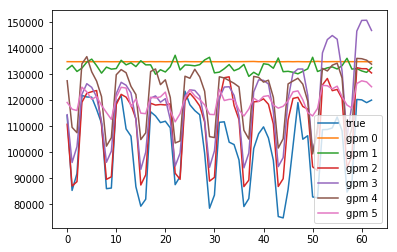

i =  17


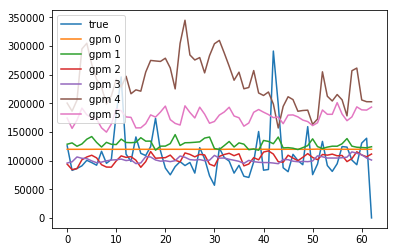

i =  21


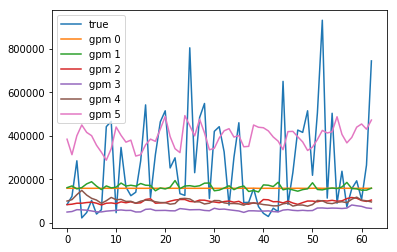

i =  37


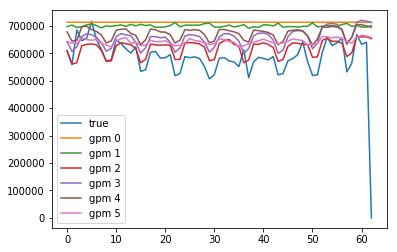

i =  48


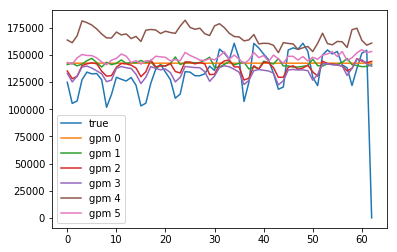

In [313]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [320]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[     2,     17,     21,     37,     48],
       [  8221,  39174,  45056,  92205, 123025]])

In [324]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[  158462.75,   158416.5 ,   152551.  ,  1278277.75,   124816.25],
       [  134884.25,   119709.  ,   158003.25,   712793.25,   142380.75]], dtype=float32)

#### Group = 4

In [325]:
gp = 4
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [326]:
Y_list.shape

(6, 740, 63)

In [327]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([324, 353, 521, 592, 726])

In [ ]:
output_log_std_p = [1.]

Group 4
i =  324


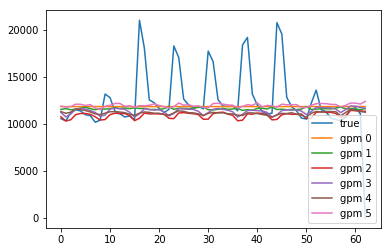

i =  353


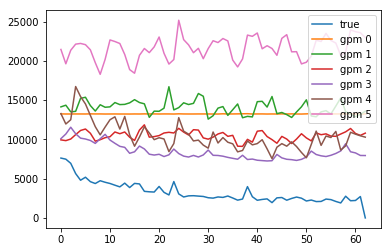

i =  521


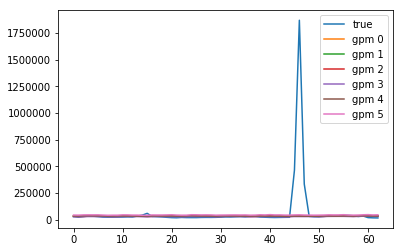

i =  592


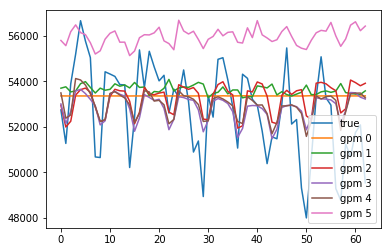

i =  726


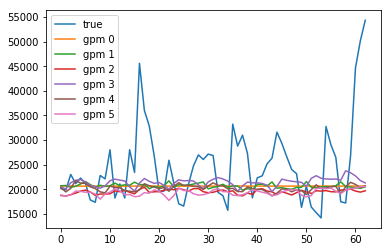

In [328]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

Group 4
i =  324


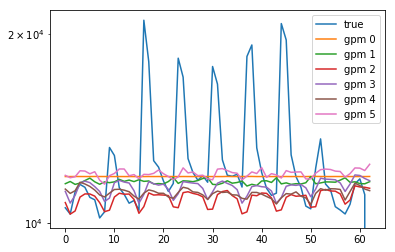

i =  353


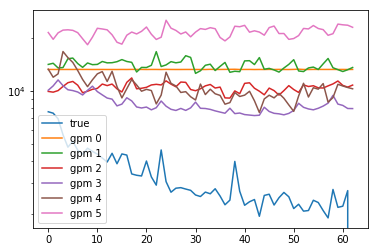

i =  521


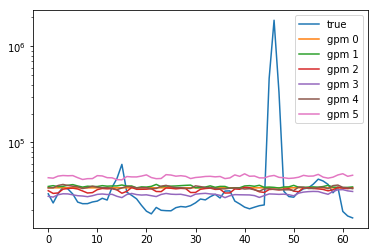

i =  592


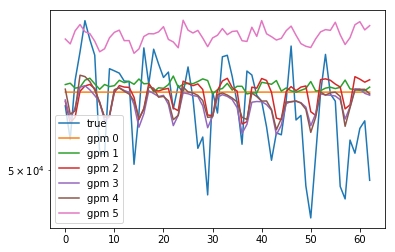

i =  726


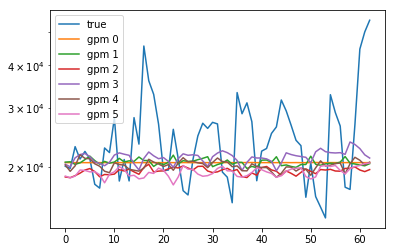

In [334]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.yscale('log')
    plt.legend(); plt.show()    

In [329]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[   324,    353,    521,    592,    726],
       [ 39850,  40205,  45078,  74689, 131296]])

In [330]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[  12261.25,    3813.75,   38985.75,   50227.75,  259744.  ],
       [  11840.75,   13227.5 ,   33733.75,   53354.5 ,   20626.25]], dtype=float32)

#### Case 131296

In [331]:
i = 131296

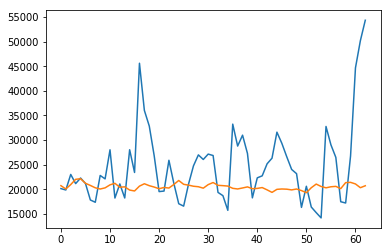

In [332]:
multi_view((Y_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [179]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

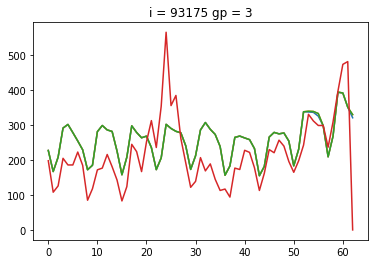

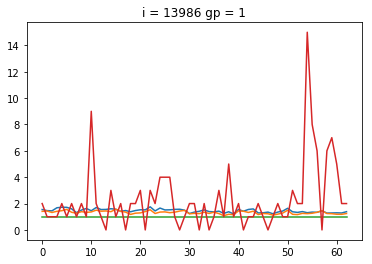

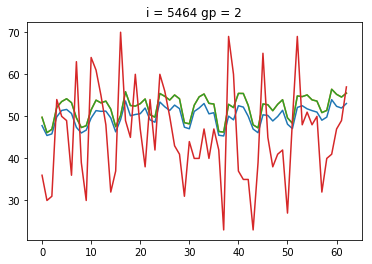

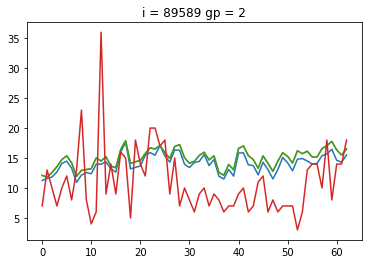

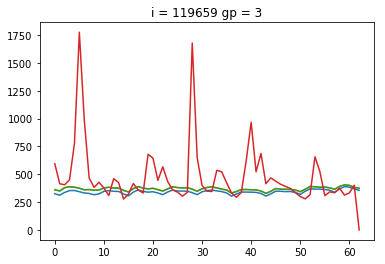

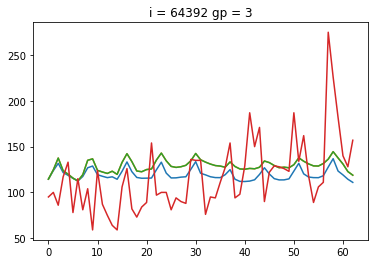

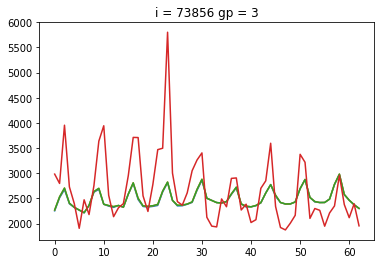

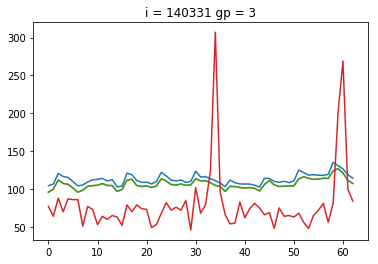

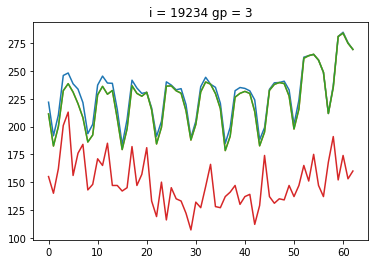

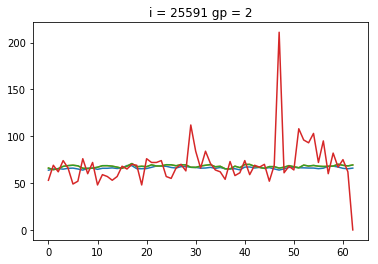

In [301]:
view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                             Y_output_pred_ori_ens_med,
                             Y_output_f_gpm, 
                             Y_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

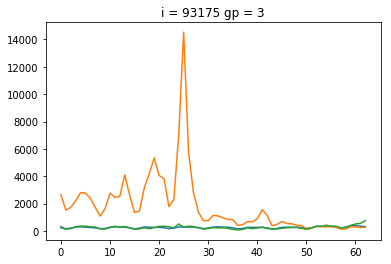

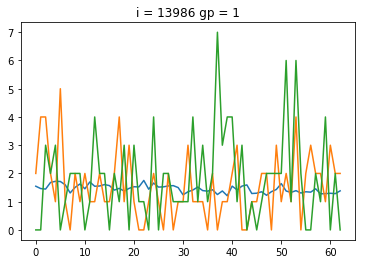

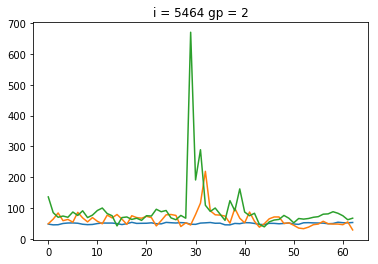

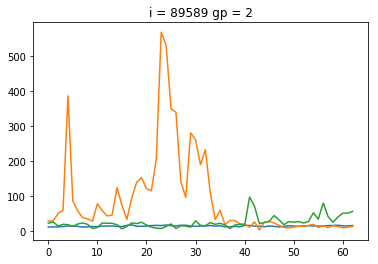

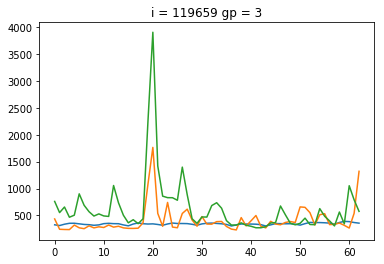

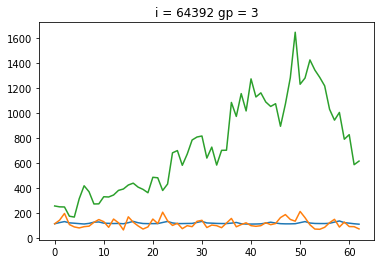

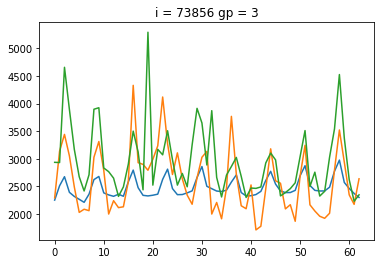

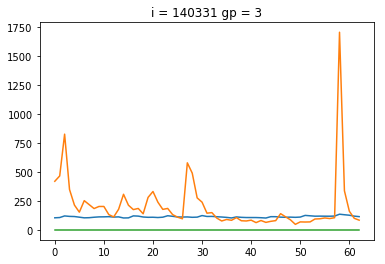

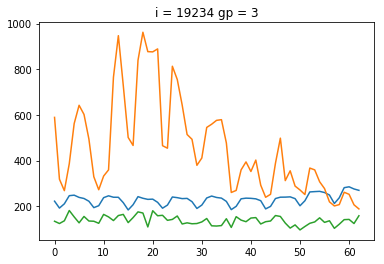

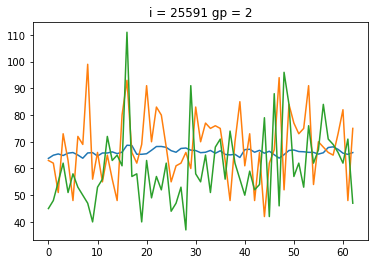

In [181]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

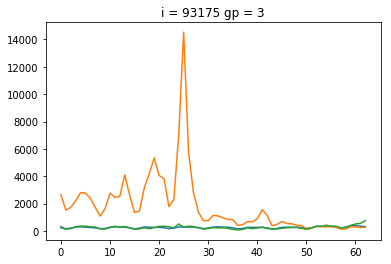

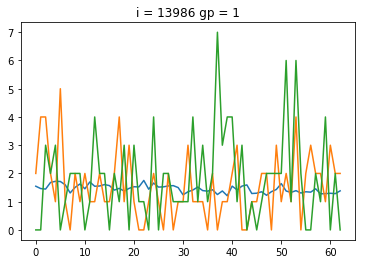

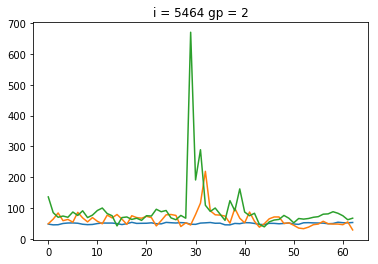

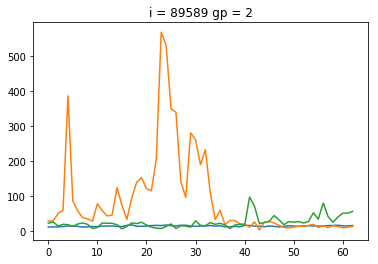

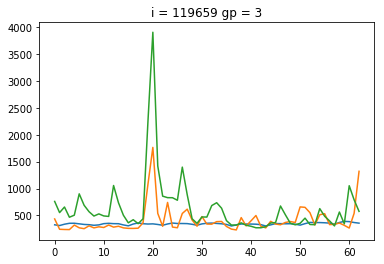

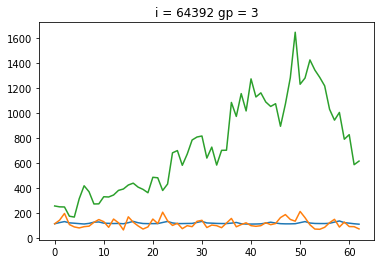

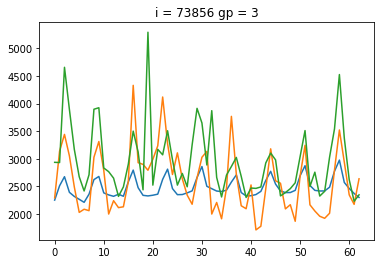

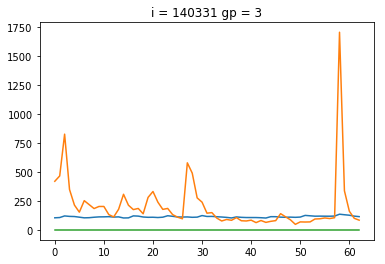

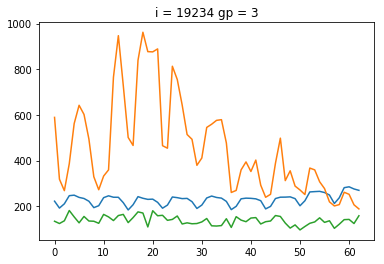

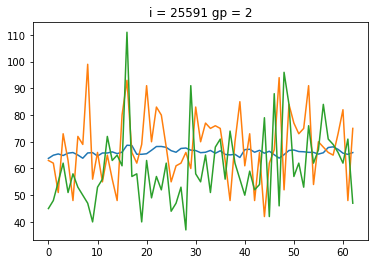

In [181]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(output_center[view_list_good].reshape(-1))
print(output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

input_center[i], output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_input_center = input_center[good_Y_index]
good_output_center = output_center[good_Y_index]
bad_input_center = input_center[bad_Y_index]
bad_output_center = output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [ ]:
Y_output_dates

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_omed, columns = Y_output_dates)  # using ensemble median combined result
result_df

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_2.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_2.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]